In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry_update as geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

from functools import reduce
from math import sqrt

In [10]:
test_phantom = phantom_update.Phantom(source_path = None,
            voxel_dims = (0.1e-3,0.1e-3,0.1e-3),
            matrix_dims = (100,100,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=11.3, scale=0.00001, label=1)
test_phantom.add_tissue_sphere((0,0,0), 2, blood)
test_phantom.add_tissue_sphere((0.25,0,0), 4, blood)

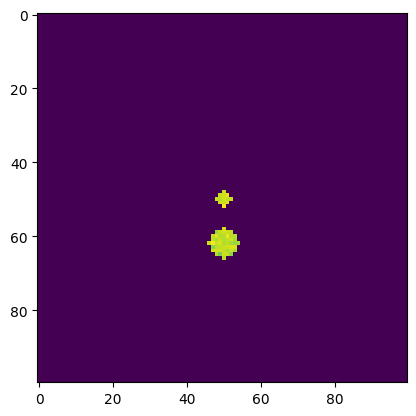

In [11]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [12]:
test_phantom.voxel_dims * test_phantom.matrix_dims * 1000

array([10., 10., 10.])

In [13]:
simprops = simulation_update.SimProperties(
                grid_size   = (5e-3,2e-3,2e-3),
                voxel_size  = (0.02e-3,0.02e-3,0.02e-3),
                PML_size    = (1,1,1),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [14]:
simprops.matrix_size

array([256, 128, 128])

In [15]:
bounds = simprops.bounds
transform = geometry.Transform((-np.pi/8,0,0),(0.001,0.001,0.0001))
# transform = geometry.Transform((0,0,0),(0,0,0))
voxel_size = simprops.voxel_size
matrix_size = simprops.matrix_size

In [16]:
out = test_phantom.crop_rotate_crop(bounds, transform, voxel_size, matrix_size)

first_crop_bounds_indices [[39 96]
 [25 68]
 [36 61]]
padding: (0, 0, 0)
first_crop_bounds_indices [[39 96]
 [25 68]
 [36 61]]
cropped_matrix (2, 100, 100, 100)
min cropped_matrix 1000.0
cropped_matrix (2, 57, 43, 25)
min rotated 1000.0
bias pre transform [0.0049353  0.00498072 0.00495   ]
bias post transform [0.00646566 0.00271293 0.00495   ]
rotated_matrix (2, 57, 43, 25)
grid size [51.2 25.6 25.6]
start [ 2  9 -1]
end [54 35 25]
bias pre second crop [0.00646566 0.00271293 0.00495   ]
bias post second crop [0.00651566 0.00276293 0.005     ]
rough_crop = (2, 52, 26, 1)
interpolated_shape = (2, 260, 130, 0)


ValueError: zero-size array to reduction operation minimum which has no identity

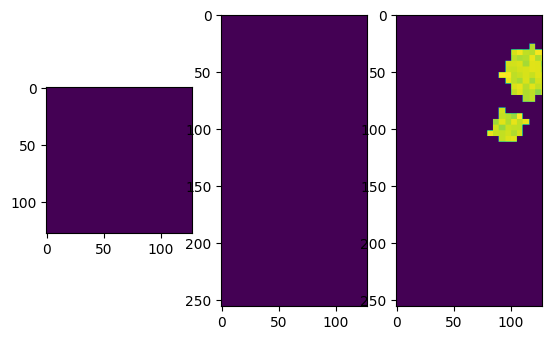

In [9]:
fig, ax = plt.subplots(1,3,)

ax[0].imshow(out[0,out.shape[1]//2,:,:])
ax[1].imshow(out[0,:,out.shape[2]//2,:])
ax[2].imshow(out[0,:,:,out.shape[3]//2])